# Risk Modeling and Optimization of a Multi-Sector Equity Portfolio

SECTION 0 — Setup & Installs


In [ ]:
# Install required packages (quiet, pinned) with graceful fallbacks
import sys
import subprocess


def _pip_install(pkg):
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--prefer-binary", pkg]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        msg = (result.stderr or result.stdout or "").strip()
        print(f"[WARN] Failed to install {pkg}.")
        if msg:
            print(msg.splitlines()[-1])
        return False
    print(f"[OK] Installed {pkg}")
    return True

# Bootstrap tools (safe to skip if unavailable)
for bootstrap in ["pip==23.3.2", "setuptools==68.2.2", "wheel==0.41.3"]:
    _pip_install(bootstrap)

packages = [
    "yfinance==0.2.36",
    "pandas==2.1.4",
    "numpy==1.26.4",
    "matplotlib==3.8.2",
    "scipy==1.11.4",
    "statsmodels==0.14.1",
    "arch==6.3.0",
    "cvxpy==1.4.2",
    "scikit-learn==1.3.2",
    "pandas_datareader==0.10.0",
]

for pkg in packages:
    _pip_install(pkg)

# Restart runtime only if necessary (e.g., rerun after imports)
needs_restart = any(name in sys.modules for name in [
    "numpy", "pandas", "matplotlib", "scipy", "statsmodels", "arch",
    "cvxpy", "sklearn", "pandas_datareader", "yfinance"
])

if needs_restart and "google.colab" in sys.modules:
    import os
    print("[INFO] Restarting runtime to load updated packages...")
    os.kill(os.getpid(), 9)
else:
    print("[INFO] Runtime restart not required.")


[OK] Installed pip==23.3.2
[OK] Installed setuptools==68.2.2
[OK] Installed wheel==0.41.3
[OK] Installed yfinance==0.2.36
[OK] Installed pandas==2.1.4
[OK] Installed numpy==1.26.4
[OK] Installed matplotlib==3.8.2
[OK] Installed scipy==1.11.4
[OK] Installed statsmodels==0.14.1
[OK] Installed arch==6.3.0
[OK] Installed cvxpy==1.4.2
[OK] Installed scikit-learn==1.3.2


In [1]:
import os
import sys
import time
import math
import random
from importlib import metadata as importlib_metadata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

# Dependency check

def check_dependency(package_name, module_name=None):
    module_name = module_name or package_name
    try:
        module = __import__(module_name)
        version = getattr(module, "__version__", None)
        if version is None:
            try:
                version = importlib_metadata.version(package_name)
            except Exception:
                version = "unknown"
        print(f"[OK] {package_name}=={version}")
        return module
    except Exception as exc:
        print(f"[WARN] {package_name} failed to import: {exc}")
        return None

# Core packages
np_mod = check_dependency("numpy", "numpy")
pd_mod = check_dependency("pandas", "pandas")
plt_mod = check_dependency("matplotlib", "matplotlib")

# Optional / specialized packages
_yf = check_dependency("yfinance", "yfinance")
_pdr = check_dependency("pandas_datareader", "pandas_datareader")
_cvx = check_dependency("cvxpy", "cvxpy")
_scipy = check_dependency("scipy", "scipy")

HAS_YF = _yf is not None
HAS_PDR = _pdr is not None
HAS_CVXPY = _cvx is not None
HAS_SCIPY = _scipy is not None

# Matplotlib and pandas settings
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# Constants
SEED = 319302
TRADING_DAYS = 252
RF_RATE = 0.0

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Editable inputs
TICKERS = {
    "Tech": ["AAPL", "MSFT"],
    "Financials": ["JPM", "BAC"],
    "Healthcare": ["JNJ", "PFE"],
}

ALL_TICKERS = [t for sector in TICKERS.values() for t in sector]
START_DATE = "2021-01-01"
END_DATE = pd.Timestamp.today().strftime("%Y-%m-%d")


def ensure(condition, message):
    if not condition:
        raise ValueError(message)

print(f"Using tickers: {ALL_TICKERS}")
print(f"Date range: {START_DATE} to {END_DATE}")
print("Runtime restart not required.")


[OK] numpy==1.26.4
[OK] pandas==2.1.4
[OK] matplotlib==3.8.2
[OK] yfinance==0.2.36
[OK] pandas_datareader==0.10.0
[OK] cvxpy==1.4.2
[OK] scipy==1.11.4
Using tickers: ['AAPL', 'MSFT', 'JPM', 'BAC', 'JNJ', 'PFE']
Date range: 2021-01-01 to 2026-02-06
Runtime restart not required.


SECTION 1 — Data Pull (robust)


In [2]:
def _missing_report(df, label):
    total = df.size if df is not None else 0
    missing = df.isna().sum().sum() if total else 0
    pct = (missing / total) * 100 if total else 100.0
    report = pd.DataFrame({
        "label": [label],
        "rows": [df.shape[0] if df is not None else 0],
        "cols": [df.shape[1] if df is not None else 0],
        "missing_pct": [round(pct, 2)],
    })
    return report


def _is_bad_prices(df):
    if df is None or df.empty:
        return True
    if df.dropna(how="all").empty:
        return True
    missing_pct = df.isna().mean().mean()
    return missing_pct > 0.2


def get_prices(tickers, start, end):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    bdays = pd.date_range(start, end, freq="B")

    prices = None

    # 1) Try yfinance
    if HAS_YF:
        try:
            import yfinance as yf
            yf_data = yf.download(
                tickers,
                start=start,
                end=end,
                auto_adjust=False,
                progress=False,
                group_by="column",
                threads=False,
            )
            if isinstance(yf_data, pd.DataFrame) and "Adj Close" in yf_data:
                prices = yf_data["Adj Close"].copy()
            elif isinstance(yf_data, pd.DataFrame) and "Close" in yf_data:
                prices = yf_data["Close"].copy()
            else:
                prices = yf_data.copy()
        except Exception as exc:
            print(f"[WARN] yfinance failed: {exc}")
    else:
        print("[WARN] yfinance not available, skipping.")

    # 2) Try Stooq via pandas_datareader if needed
    if _is_bad_prices(prices):
        print("[WARN] Falling back to Stooq via pandas_datareader.")
        if HAS_PDR:
            try:
                from pandas_datareader import data as pdr
                frames = []
                for t in tickers:
                    symbol = f"{t}.US"
                    df = pdr.DataReader(symbol, "stooq", start, end).sort_index()
                    frames.append(df["Close"].rename(t))
                prices = pd.concat(frames, axis=1)
            except Exception as exc:
                print(f"[WARN] Stooq download failed: {exc}")
        else:
            print("[WARN] pandas_datareader not available, skipping Stooq.")

    # 3) Synthetic GBM if needed
    if _is_bad_prices(prices):
        print("[WARN] Generating synthetic GBM price paths.")
        n_assets = len(tickers)
        mu_daily = 0.08 / TRADING_DAYS
        sigma_daily = 0.20 / math.sqrt(TRADING_DAYS)
        shocks = np.random.normal(mu_daily, sigma_daily, size=(len(bdays), n_assets))
        prices = pd.DataFrame(
            100.0 * np.exp(np.cumsum(shocks, axis=0)),
            index=bdays,
            columns=tickers,
        )

    # Align to business days
    prices = prices.reindex(bdays)

    # Diagnostics before cleaning
    report_before = _missing_report(prices, "before_clean")

    # Clean: forward-fill then drop remaining NaNs
    prices = prices.ffill().dropna()

    report_after = _missing_report(prices, "after_clean")
    report = pd.concat([report_before, report_after], ignore_index=True)

    print("Price diagnostics:")
    display(report)

    # Validate
    ensure(prices.shape[0] >= 30, "Not enough rows after cleaning to proceed.")
    ensure(prices.shape[1] >= 2, "Need at least two assets to proceed.")

    return prices, report


prices, price_missing_report = get_prices(ALL_TICKERS, START_DATE, END_DATE)
print(f"Cleaned prices shape: {prices.shape}")
print(prices.head())


ERROR:yfinance:Failed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:Failed to get ticker 'BAC' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:Failed to get ticker 'PFE' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:Failed to get ticker 'MSFT' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:Failed to get ticker 'JNJ' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:
6 Failed downloads:
ERROR:yfinance:['JPM', 'BAC', 'AAPL', 'PFE', 'MSFT', 'JNJ']: Exception('%ticker%: No timezone found, symbol may be delisted')


[WARN] Falling back to Stooq via pandas_datareader.
Price diagnostics:


,label,rows,cols,missing_pct
0,before_clean,1331,6,3.91
1,after_clean,1330,6,0.00


Cleaned prices shape: (1330, 6)
               AAPL     MSFT      JPM      BAC      JNJ      PFE
2021-01-04  125.979  210.429  119.033  28.7930  148.755  34.3100
2021-01-05  127.520  210.623  119.671  29.0129  150.491  34.6643
2021-01-06  123.249  205.161  125.291  30.8257  151.923  34.3658
2021-01-07  127.433  210.996  129.407  31.5063  152.423  34.5423
2021-01-08  128.542  212.294  129.545  31.1891  152.109  34.6077


SECTION 2 — Returns & Basic Stats


Return summary stats:


,mean_daily,vol_daily,skew,kurtosis,min,max,mean_ann,vol_ann
AAPL,0.000737,0.017170,0.470280,6.886515,-0.092458,0.153295,0.185629,0.272569
MSFT,0.000602,0.016166,0.020672,4.184582,-0.099931,0.101337,0.151667,0.256629
JPM,0.000834,0.015046,0.097305,5.438480,-0.080502,0.115445,0.210134,0.238844
BAC,0.000625,0.016681,0.001547,3.508954,-0.110633,0.084288,0.157583,0.264801
JNJ,0.000407,0.010356,0.076621,5.275742,-0.075917,0.061932,0.102458,0.164398
PFE,-0.000073,0.015655,0.486227,3.282964,-0.067180,0.108550,-0.018321,0.248508


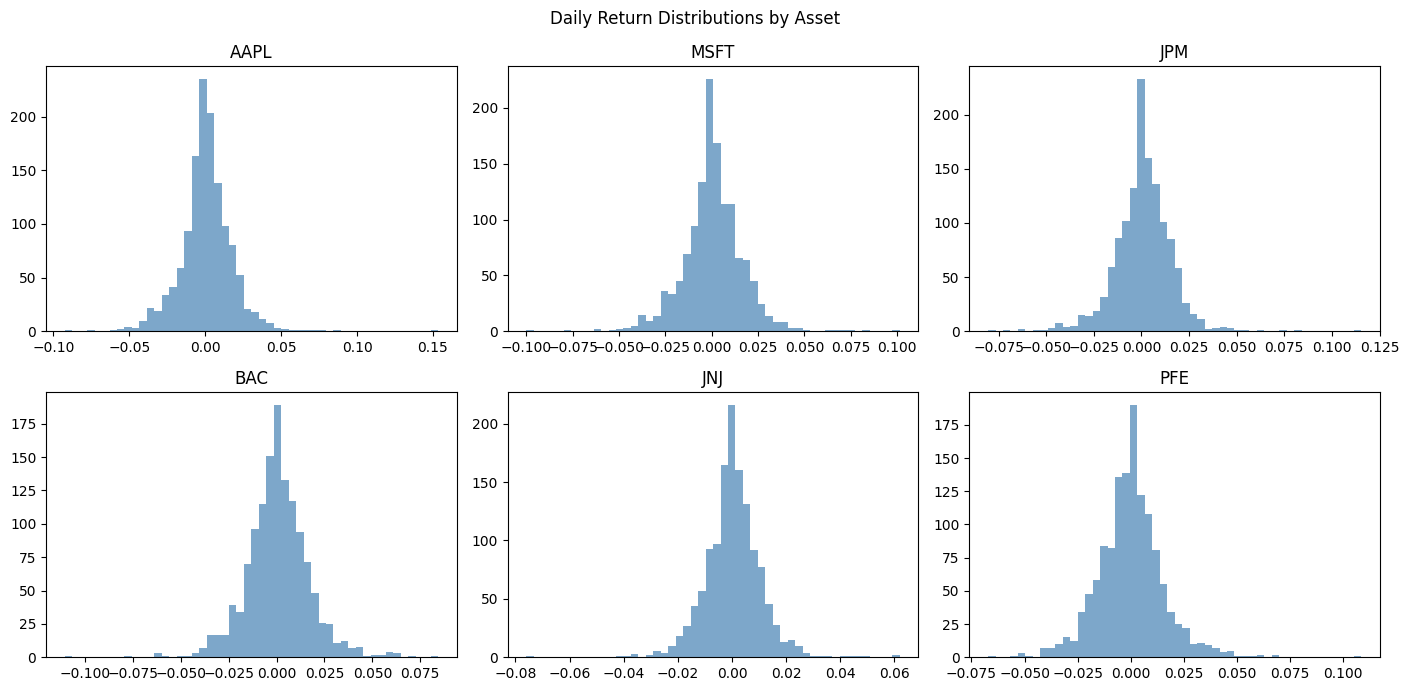

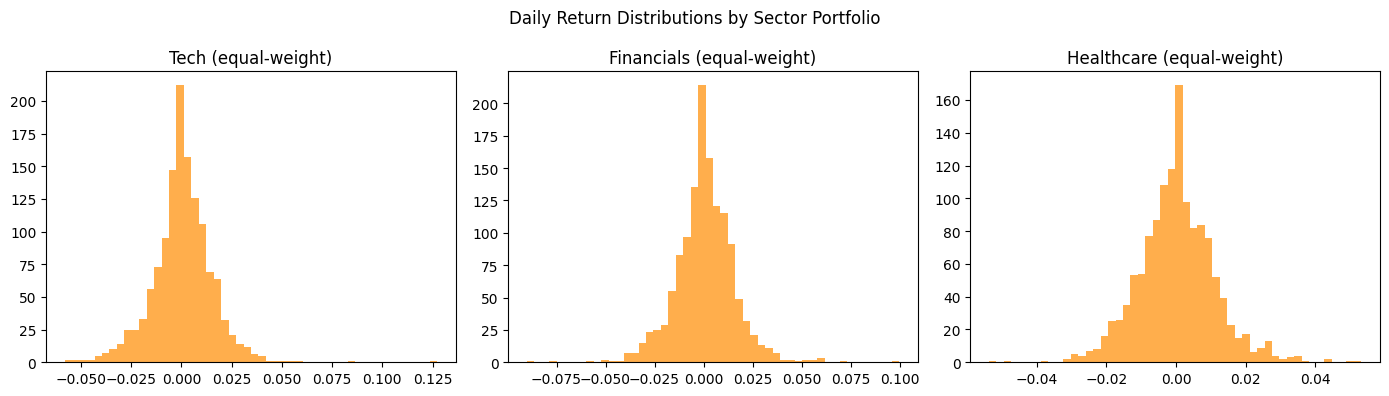

In [3]:
simple_returns = prices.pct_change().replace([np.inf, -np.inf], np.nan)
log_returns = np.log(prices / prices.shift(1)).replace([np.inf, -np.inf], np.nan)

simple_returns = simple_returns.dropna(how="all")
log_returns = log_returns.dropna(how="all")

ensure(simple_returns.shape[0] >= 20, "Not enough return observations to proceed.")

summary_stats = pd.DataFrame(index=simple_returns.columns)
summary_stats["mean_daily"] = simple_returns.mean()
summary_stats["vol_daily"] = simple_returns.std()
summary_stats["skew"] = simple_returns.skew()
summary_stats["kurtosis"] = simple_returns.kurtosis()
summary_stats["min"] = simple_returns.min()
summary_stats["max"] = simple_returns.max()
summary_stats["mean_ann"] = summary_stats["mean_daily"] * TRADING_DAYS
summary_stats["vol_ann"] = summary_stats["vol_daily"] * math.sqrt(TRADING_DAYS)

print("Return summary stats:")
display(summary_stats)

# Asset return histograms
try:
    n_assets = len(ALL_TICKERS)
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))
    axes = axes.flatten()
    for i, t in enumerate(ALL_TICKERS):
        axes[i].hist(simple_returns[t].dropna(), bins=50, alpha=0.7, color="steelblue")
        axes[i].set_title(t)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    fig.suptitle("Daily Return Distributions by Asset")
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f"[WARN] Asset histogram plot failed: {exc}")

# Sector return histograms (equal-weight within sector)
sector_returns = {}
for sector, tickers in TICKERS.items():
    sector_returns[sector] = simple_returns[tickers].mean(axis=1)
sector_returns = pd.DataFrame(sector_returns)

try:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for ax, sector in zip(axes, sector_returns.columns):
        ax.hist(sector_returns[sector].dropna(), bins=50, alpha=0.7, color="darkorange")
        ax.set_title(f"{sector} (equal-weight)")
    fig.suptitle("Daily Return Distributions by Sector Portfolio")
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f"[WARN] Sector histogram plot failed: {exc}")


SECTION 3 — Correlation/Covariance


Daily covariance:


,AAPL,MSFT,JPM,BAC,JNJ,PFE
AAPL,0.000295,0.000170,0.000089,0.000098,0.000027,0.000052
MSFT,0.000170,0.000261,0.000072,0.000075,0.000011,0.000034
JPM,0.000089,0.000072,0.000226,0.000204,0.000030,0.000045
BAC,0.000098,0.000075,0.000204,0.000278,0.000029,0.000048
JNJ,0.000027,0.000011,0.000030,0.000029,0.000107,0.000068
PFE,0.000052,0.000034,0.000045,0.000048,0.000068,0.000245


Correlation matrix:


,AAPL,MSFT,JPM,BAC,JNJ,PFE
AAPL,1.000000,0.612119,0.344716,0.341602,0.154119,0.193531
MSFT,0.612119,1.000000,0.297606,0.278407,0.064478,0.135133
JPM,0.344716,0.297606,1.000000,0.813362,0.192704,0.191542
BAC,0.341602,0.278407,0.813362,1.000000,0.167960,0.182686
JNJ,0.154119,0.064478,0.192704,0.167960,1.000000,0.418709
PFE,0.193531,0.135133,0.191542,0.182686,0.418709,1.000000


Annualized covariance:


,AAPL,MSFT,JPM,BAC,JNJ,PFE
AAPL,0.074294,0.042817,0.022442,0.024656,0.006906,0.013109
MSFT,0.042817,0.065858,0.018242,0.018919,0.002720,0.008618
JPM,0.022442,0.018242,0.057046,0.051442,0.007567,0.011369
BAC,0.024656,0.018919,0.051442,0.070120,0.007312,0.012022
JNJ,0.006906,0.002720,0.007567,0.007312,0.027027,0.017106
PFE,0.013109,0.008618,0.011369,0.012022,0.017106,0.061756


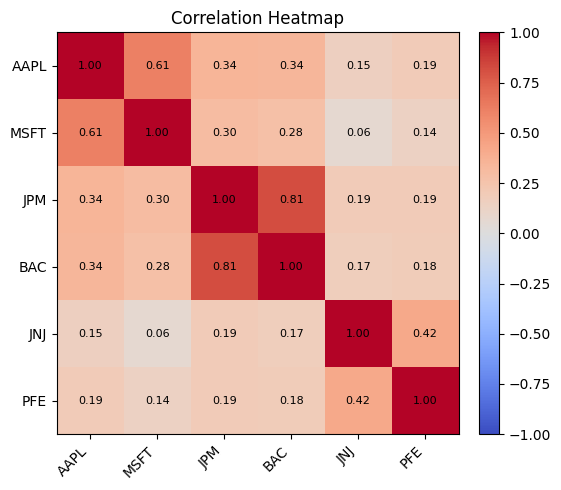

In [4]:
cov_daily = simple_returns.cov()
corr = simple_returns.corr()
cov_ann = cov_daily * TRADING_DAYS

print("Daily covariance:")
display(cov_daily)
print("Correlation matrix:")
display(corr)
print("Annualized covariance:")
display(cov_ann)

# Correlation heatmap (matplotlib only)
try:
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.index)
    for i in range(len(corr.index)):
        for j in range(len(corr.columns)):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=8)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f"[WARN] Correlation heatmap failed: {exc}")


SECTION 4 — Portfolio Construction


In [5]:
sector_map = {}
for sector, tickers in TICKERS.items():
    for t in tickers:
        sector_map[t] = sector

n_assets = len(ALL_TICKERS)
weights_equal = pd.Series(1.0 / n_assets, index=ALL_TICKERS)

weights_sector_equal = pd.Series(0.0, index=ALL_TICKERS)
for sector, tickers in TICKERS.items():
    sector_weight = 1.0 / len(TICKERS)
    for t in tickers:
        weights_sector_equal[t] = sector_weight / len(tickers)

# Validation
ensure(abs(weights_equal.sum() - 1.0) < 1e-8, "Equal-weight portfolio does not sum to 1.")
ensure((weights_equal >= 0).all(), "Equal-weight portfolio has negative weights.")
ensure(abs(weights_sector_equal.sum() - 1.0) < 1e-8, "Sector-equal portfolio does not sum to 1.")
ensure((weights_sector_equal >= 0).all(), "Sector-equal portfolio has negative weights.")

portfolio_returns = pd.DataFrame({
    "equal_weight": simple_returns @ weights_equal,
    "sector_equal": simple_returns @ weights_sector_equal,
})

sector_portfolios = pd.DataFrame({
    sector: simple_returns[tickers].mean(axis=1) for sector, tickers in TICKERS.items()
})

print("Portfolio weights (equal-weight):")
display(weights_equal.to_frame("weight"))
print("Portfolio weights (sector-equal):")
display(weights_sector_equal.to_frame("weight"))

print("Portfolio returns preview:")
display(portfolio_returns.head())


Portfolio weights (equal-weight):


,weight
AAPL,0.166667
MSFT,0.166667
JPM,0.166667
BAC,0.166667
JNJ,0.166667
PFE,0.166667


Portfolio weights (sector-equal):


,weight
AAPL,0.166667
MSFT,0.166667
JPM,0.166667
BAC,0.166667
JNJ,0.166667
PFE,0.166667


Portfolio returns preview:


,equal_weight,sector_equal
2021-01-05,0.008025,0.008025
2021-01-06,0.008487,0.008487
2021-01-07,0.020958,0.020958
2021-01-08,0.000948,0.000948
2021-01-11,0.001951,0.001951


SECTION 5 — Risk Metrics


Risk metrics:


,ann_vol,sharpe,max_drawdown
equal_weight,0.156932,0.838104,-0.251614
sector_equal,0.156932,0.838104,-0.251614


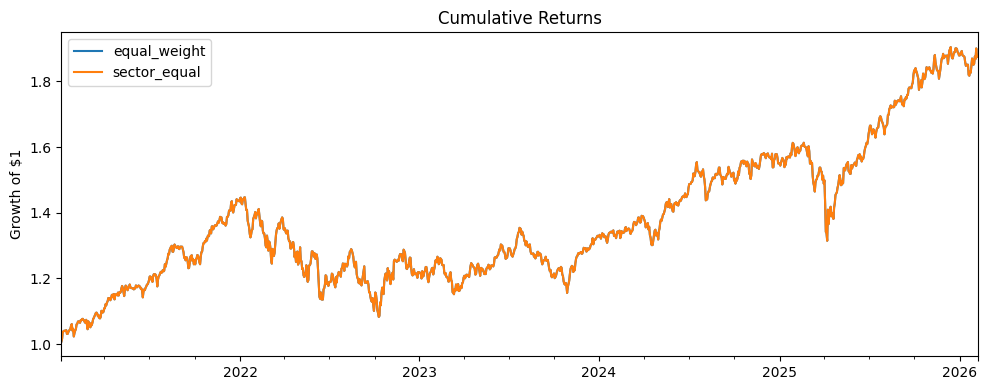

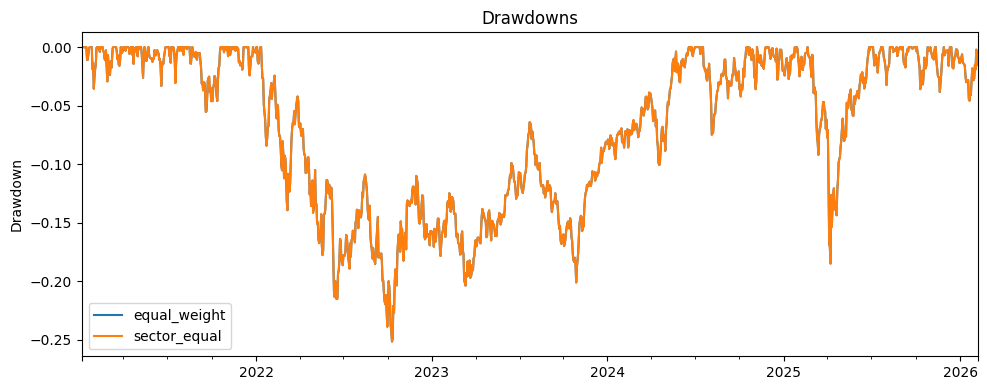

In [6]:
def annualized_vol(series):
    return series.std() * math.sqrt(TRADING_DAYS)


def sharpe_ratio(series, rf=RF_RATE):
    vol = annualized_vol(series)
    if vol == 0:
        return np.nan
    return (series.mean() * TRADING_DAYS - rf) / vol


def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = cumulative / peak - 1.0
    return drawdown.min(), drawdown


risk_metrics = pd.DataFrame(index=portfolio_returns.columns)
risk_metrics["ann_vol"] = portfolio_returns.apply(annualized_vol)
risk_metrics["sharpe"] = portfolio_returns.apply(sharpe_ratio)
risk_metrics["max_drawdown"] = portfolio_returns.apply(lambda s: max_drawdown(s)[0])

print("Risk metrics:")
display(risk_metrics)

# Plot cumulative returns
try:
    cumulative = (1 + portfolio_returns).cumprod()
    cumulative.plot(figsize=(10, 4), title="Cumulative Returns")
    plt.ylabel("Growth of $1")
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f"[WARN] Cumulative return plot failed: {exc}")

# Plot drawdowns
try:
    drawdowns = pd.DataFrame({
        name: max_drawdown(portfolio_returns[name])[1] for name in portfolio_returns.columns
    })
    drawdowns.plot(figsize=(10, 4), title="Drawdowns")
    plt.ylabel("Drawdown")
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f"[WARN] Drawdown plot failed: {exc}")


SECTION 6 — VaR & CVaR (95%, 99%)


In [7]:
def historical_var_cvar(series, alpha=0.95):
    s = series.dropna()
    ensure(len(s) >= 20, "Not enough data for historical VaR/CVaR.")
    q = np.quantile(s, 1 - alpha)
    var = -q
    tail = s[s <= q]
    cvar = -tail.mean() if not tail.empty else var
    return var, cvar


def normal_var_cvar(series, alpha=0.95):
    s = series.dropna()
    ensure(len(s) >= 20, "Not enough data for normal VaR/CVaR.")
    mu = s.mean()
    sigma = s.std()
    if sigma == 0:
        return np.nan, np.nan
    if HAS_SCIPY:
        from scipy.stats import norm
        z = norm.ppf(1 - alpha)
        var = -(mu + sigma * z)
        cvar = -(mu + sigma * norm.pdf(z) / (1 - alpha))
        return var, cvar
    else:
        print("[WARN] SciPy not available; using historical VaR/CVaR instead.")
        return historical_var_cvar(series, alpha)


# Build sector portfolios (equal-weight within sector)
sector_portfolios = pd.DataFrame({
    sector: simple_returns[tickers].mean(axis=1) for sector, tickers in TICKERS.items()
})

# Collect portfolios to evaluate
portfolios_for_var = {
    "Tech": sector_portfolios["Tech"],
    "Financials": sector_portfolios["Financials"],
    "Healthcare": sector_portfolios["Healthcare"],
    "Total_equal_weight": portfolio_returns["equal_weight"],
    "Total_sector_equal": portfolio_returns["sector_equal"],
}

rows_hist = []
rows_norm = []
for name, series in portfolios_for_var.items():
    for alpha in [0.95, 0.99]:
        h_var, h_cvar = historical_var_cvar(series, alpha)
        n_var, n_cvar = normal_var_cvar(series, alpha)
        rows_hist.append({"portfolio": name, "alpha": alpha, "VaR": h_var, "CVaR": h_cvar})
        rows_norm.append({"portfolio": name, "alpha": alpha, "VaR": n_var, "CVaR": n_cvar})

var_cvar_hist = pd.DataFrame(rows_hist)
var_cvar_norm = pd.DataFrame(rows_norm)

print("Historical VaR/CVaR:")
display(var_cvar_hist)
print("Normal VaR/CVaR:")
display(var_cvar_norm)


Historical VaR/CVaR:


,portfolio,alpha,VaR,CVaR
0,Tech,0.95,0.024747,0.033598
1,Tech,0.99,0.039382,0.046678
2,Financials,0.95,0.023807,0.033520
3,Financials,0.99,0.037569,0.049272
4,Healthcare,0.95,0.017494,0.022934
5,Healthcare,0.99,0.025951,0.032332
6,Total_equal_weight,0.95,0.015626,0.022432
7,Total_equal_weight,0.99,0.026779,0.034414
8,Total_sector_equal,0.95,0.015626,0.022432
9,Total_sector_equal,0.99,0.026779,0.034414


Normal VaR/CVaR:


,portfolio,alpha,VaR,CVaR
0,Tech,0.95,0.023948,-0.031541
1,Tech,0.99,0.034148,-0.040558
2,Financials,0.95,0.024119,-0.031891
3,Financials,0.99,0.034415,-0.040993
4,Healthcare,0.95,0.018002,-0.022952
5,Healthcare,0.99,0.025530,-0.029607
6,Total_equal_weight,0.95,0.015739,-0.020913
7,Total_equal_weight,0.99,0.022476,-0.026870
8,Total_sector_equal,0.95,0.015739,-0.020913
9,Total_sector_equal,0.99,0.022476,-0.026870


SECTION 7 — Monte Carlo Simulation


Simulated VaR/CVaR:


,portfolio,alpha,VaR,CVaR
0,equal_weight,0.95,0.016090,0.020067
1,equal_weight,0.99,0.022582,0.025967
2,sector_equal,0.95,0.016090,0.020067
3,sector_equal,0.99,0.022582,0.025967


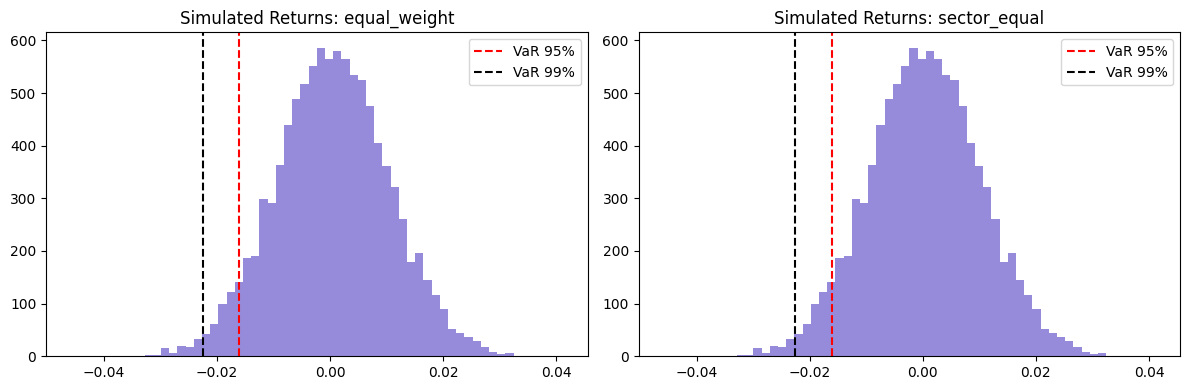

In [8]:
def make_psd(matrix, epsilon=1e-6):
    vals, vecs = np.linalg.eigh(matrix)
    vals_clipped = np.clip(vals, epsilon, None)
    return vecs @ np.diag(vals_clipped) @ vecs.T


n_sims = 10_000
mu = simple_returns.mean().values
Sigma = simple_returns.cov().values

# Ensure PSD
if np.any(np.linalg.eigvalsh(Sigma) < 0):
    print("[WARN] Covariance not PSD; applying eigenvalue clipping.")
    Sigma_psd = make_psd(Sigma)
else:
    Sigma_psd = Sigma

try:
    sim_asset = np.random.multivariate_normal(mu, Sigma_psd, size=n_sims)
except Exception as exc:
    print(f"[WARN] Multivariate normal failed: {exc}")
    sim_asset = np.random.normal(mu, np.sqrt(np.diag(Sigma_psd)), size=(n_sims, len(mu)))

sim_equal = sim_asset @ weights_equal.values
sim_sector = sim_asset @ weights_sector_equal.values

sim_results = pd.DataFrame({
    "equal_weight": sim_equal,
    "sector_equal": sim_sector,
})

# Simulated VaR/CVaR
sim_var_rows = []
for name in sim_results.columns:
    for alpha in [0.95, 0.99]:
        var, cvar = historical_var_cvar(pd.Series(sim_results[name]), alpha)
        sim_var_rows.append({"portfolio": name, "alpha": alpha, "VaR": var, "CVaR": cvar})

sim_var_cvar = pd.DataFrame(sim_var_rows)
print("Simulated VaR/CVaR:")
display(sim_var_cvar)

# Plot simulation distributions
try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for ax, name in zip(axes, sim_results.columns):
        ax.hist(sim_results[name], bins=60, alpha=0.7, color="slateblue")
        for alpha, color in zip([0.95, 0.99], ["red", "black"]):
            var, _ = historical_var_cvar(pd.Series(sim_results[name]), alpha)
            ax.axvline(-var, color=color, linestyle="--", label=f"VaR {int(alpha*100)}%")
        ax.set_title(f"Simulated Returns: {name}")
        ax.legend()
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f"[WARN] Simulation plot failed: {exc}")


SECTION 8 — Stress Tests


In [9]:
shock_tech = pd.Series(0.0, index=ALL_TICKERS)
shock_fin = pd.Series(0.0, index=ALL_TICKERS)

for t in TICKERS["Tech"]:
    shock_tech[t] = -0.05
for t in TICKERS["Financials"]:
    shock_fin[t] = -0.06

stress_table = pd.DataFrame(index=["Tech -5%", "Financials -6%"], columns=["equal_weight", "sector_equal"])
stress_table.loc["Tech -5%", "equal_weight"] = float((weights_equal * shock_tech).sum())
stress_table.loc["Tech -5%", "sector_equal"] = float((weights_sector_equal * shock_tech).sum())
stress_table.loc["Financials -6%", "equal_weight"] = float((weights_equal * shock_fin).sum())
stress_table.loc["Financials -6%", "sector_equal"] = float((weights_sector_equal * shock_fin).sum())

print("Stress test P&L impact (1-day return):")
display(stress_table)


Stress test P&L impact (1-day return):


,equal_weight,sector_equal
Tech -5%,-0.016667,-0.016667
Financials -6%,-0.02,-0.02


SECTION 9 — Optimization (cvxpy)


In [10]:
def normalize_weights(w):
    w = np.clip(np.array(w, dtype=float), 0.0, None)
    total = w.sum()
    if total == 0:
        return np.ones_like(w) / len(w)
    return w / total


def min_variance_approx(Sigma):
    try:
        inv = np.linalg.pinv(Sigma)
        ones = np.ones(Sigma.shape[0])
        w = inv @ ones
        return normalize_weights(w)
    except Exception as exc:
        print(f"[WARN] Min-variance approximation failed: {exc}")
        return np.ones(Sigma.shape[0]) / Sigma.shape[0]


def risk_parity_heuristic(returns_df):
    vol = returns_df.std().values
    inv_vol = np.where(vol > 0, 1.0 / vol, 0.0)
    return normalize_weights(inv_vol)


def solve_mean_variance(mu, Sigma, lam=10.0):
    if not HAS_CVXPY:
        print("[WARN] cvxpy not available; using min-variance approximation.")
        return min_variance_approx(Sigma)

    import cvxpy as cp
    n = len(mu)
    w = cp.Variable(n)
    objective = cp.Maximize(mu @ w - lam * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0]
    problem = cp.Problem(objective, constraints)

    for solver in ["OSQP", "ECOS", "SCS"]:
        try:
            problem.solve(solver=solver, verbose=False)
            if w.value is not None:
                return normalize_weights(w.value)
        except Exception as exc:
            print(f"[WARN] Mean-variance solver {solver} failed: {exc}")

    print("[WARN] Mean-variance optimization failed; using min-variance approximation.")
    return min_variance_approx(Sigma)


def solve_cvar(returns_df, alpha=0.95):
    if not HAS_CVXPY:
        print("[WARN] cvxpy not available; using risk-parity heuristic.")
        return risk_parity_heuristic(returns_df)

    import cvxpy as cp
    R = returns_df.values
    t = cp.Variable()
    w = cp.Variable(R.shape[1])
    u = cp.Variable(R.shape[0])

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        u >= 0,
        u >= -R @ w - t,
    ]

    objective = cp.Minimize(t + (1.0 / ((1 - alpha) * R.shape[0])) * cp.sum(u))
    problem = cp.Problem(objective, constraints)

    for solver in ["ECOS", "SCS", "OSQP"]:
        try:
            problem.solve(solver=solver, verbose=False)
            if w.value is not None:
                return normalize_weights(w.value)
        except Exception as exc:
            print(f"[WARN] CVaR solver {solver} failed: {exc}")

    print("[WARN] CVaR optimization failed; using risk-parity heuristic.")
    return risk_parity_heuristic(returns_df)


mu_ann = simple_returns.mean().values * TRADING_DAYS
Sigma_ann = simple_returns.cov().values * TRADING_DAYS

LAMBDA = 10.0

w_mv = solve_mean_variance(mu_ann, Sigma_ann, lam=LAMBDA)
w_cvar = solve_cvar(simple_returns, alpha=0.95)

weights_mv = pd.Series(w_mv, index=ALL_TICKERS, name="mean_variance")
weights_cvar = pd.Series(w_cvar, index=ALL_TICKERS, name="min_cvar")

# Validate
for label, w in [("mean_variance", weights_mv), ("min_cvar", weights_cvar)]:
    ensure(abs(w.sum() - 1.0) < 1e-6, f"{label} weights do not sum to 1.")
    ensure((w >= -1e-8).all(), f"{label} weights have negative values.")

weights_table = pd.concat([weights_equal.rename("equal_weight"),
                           weights_sector_equal.rename("sector_equal"),
                           weights_mv,
                           weights_cvar], axis=1)

print("Optimized weights:")
display(weights_table)

# Compare metrics
comparison_portfolios = {
    "equal_weight": simple_returns @ weights_equal,
    "sector_equal": simple_returns @ weights_sector_equal,
    "mean_variance": simple_returns @ weights_mv,
    "min_cvar": simple_returns @ weights_cvar,
}

metrics_rows = []
for name, series in comparison_portfolios.items():
    vol = annualized_vol(series)
    var_95, cvar_95 = historical_var_cvar(series, 0.95)
    metrics_rows.append({
        "portfolio": name,
        "ann_vol": vol,
        "VaR_95": var_95,
        "CVaR_95": cvar_95,
    })

opt_metrics = pd.DataFrame(metrics_rows)
print("Optimization comparison metrics:")
display(opt_metrics)


Optimized weights:


,equal_weight,sector_equal,mean_variance,min_cvar
AAPL,0.166667,0.166667,0.069302,8.105828e-02
MSFT,0.166667,0.166667,0.160962,1.687388e-01
JPM,0.166667,0.166667,0.243516,1.572118e-01
BAC,0.166667,0.166667,0.000000,9.340668e-14
JNJ,0.166667,0.166667,0.526221,5.267014e-01
PFE,0.166667,0.166667,0.000000,6.628975e-02


Optimization comparison metrics:


,portfolio,ann_vol,VaR_95,CVaR_95
0,equal_weight,0.156932,0.015626,0.022432
1,sector_equal,0.156932,0.015626,0.022432
2,mean_variance,0.137755,0.013595,0.019416
3,min_cvar,0.135443,0.013707,0.019081


SECTION 10 — Sector Risk Attribution


Asset variance contributions:


,variance_contribution
asset,
AAPL,0.077202
MSFT,0.164907
JPM,0.286999
BAC,0.000000
JNJ,0.470891
PFE,0.000000


Sector variance contributions:


,variance_contribution
Healthcare,0.470891
Financials,0.286999
Tech,0.242109


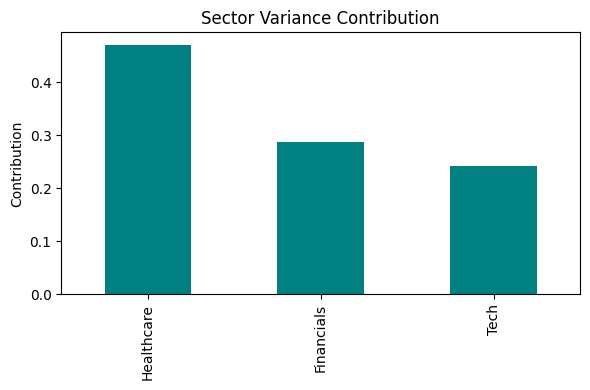

In [11]:
def variance_contributions(weights, Sigma):
    w = np.array(weights, dtype=float)
    port_var = float(w.T @ Sigma @ w)
    if port_var <= 0:
        return np.zeros_like(w), port_var
    marginal = Sigma @ w
    contrib = w * marginal / port_var
    return contrib, port_var

# Use mean-variance weights if available, else sector-equal
base_weights = weights_mv if "weights_mv" in globals() else weights_sector_equal

contrib_asset, port_var = variance_contributions(base_weights.values, Sigma_ann)
asset_contrib_table = pd.DataFrame({
    "asset": ALL_TICKERS,
    "variance_contribution": contrib_asset,
}).set_index("asset")

sector_contrib = {}
for asset, value in asset_contrib_table["variance_contribution"].items():
    sector = sector_map.get(asset, "Unknown")
    sector_contrib[sector] = sector_contrib.get(sector, 0.0) + value

sector_contrib_table = pd.DataFrame.from_dict(sector_contrib, orient="index", columns=["variance_contribution"])
sector_contrib_table = sector_contrib_table.sort_values("variance_contribution", ascending=False)

print("Asset variance contributions:")
display(asset_contrib_table)
print("Sector variance contributions:")
display(sector_contrib_table)

try:
    sector_contrib_table.plot(kind="bar", figsize=(6, 4), legend=False, color="teal")
    plt.title("Sector Variance Contribution")
    plt.ylabel("Contribution")
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print(f"[WARN] Sector contribution plot failed: {exc}")


SECTION 11 — Final Results Summary


In [12]:
# Build summary insights
corr_no_diag = corr.copy()
np.fill_diagonal(corr_no_diag.values, 0.0)
max_corr_pair = corr_no_diag.abs().stack().idxmax()
max_corr_value = corr.loc[max_corr_pair]

# Tail risk sector using historical CVaR at 95%
sector_cvar = var_cvar_hist[(var_cvar_hist["alpha"] == 0.95) & (var_cvar_hist["portfolio"].isin(TICKERS.keys()))]
if not sector_cvar.empty:
    worst_sector_row = sector_cvar.sort_values("CVaR", ascending=False).iloc[0]
    worst_sector = worst_sector_row["portfolio"]
    worst_sector_cvar = worst_sector_row["CVaR"]
else:
    worst_sector = "Unknown"
    worst_sector_cvar = np.nan

# Best optimization by lowest CVaR_95
best_opt_row = opt_metrics.sort_values("CVaR_95", ascending=True).iloc[0]
best_opt_name = best_opt_row["portfolio"]

summary_md = "\n".join([
    "### Results Summary",
    f"- Diversification insight: highest absolute correlation is {max_corr_value:.2f} between {max_corr_pair[0]} and {max_corr_pair[1]}.",
    f"- Tail risk: {worst_sector} shows the largest 95% CVaR (~{worst_sector_cvar:.4f}).",
    f"- Optimization: `{best_opt_name}` delivers the lowest 95% CVaR among compared portfolios.",
    "- Limitations: results use historical returns; regime shifts and transaction costs are not modeled.",
    "- Extensions: include factor models, robust covariance, and rolling re-optimization.",
])

display(Markdown(summary_md))

# EXPORTS
export_dir = "/content"
try:
    os.makedirs(export_dir, exist_ok=True)
    test_path = os.path.join(export_dir, "_write_test.tmp")
    with open(test_path, "w") as f:
        f.write("ok")
    os.remove(test_path)
except Exception as exc:
    print(f"[WARN] Cannot write to /content ({exc}); using ./exports instead.")
    export_dir = "./exports"
    os.makedirs(export_dir, exist_ok=True)

# Key tables to export
export_tables = {
    "price_missing_report": price_missing_report,
    "summary_stats": summary_stats,
    "cov_daily": cov_daily,
    "corr": corr,
    "cov_ann": cov_ann,
    "risk_metrics": risk_metrics,
    "var_cvar_hist": var_cvar_hist,
    "var_cvar_norm": var_cvar_norm,
    "sim_var_cvar": sim_var_cvar,
    "stress_table": stress_table,
    "weights_table": weights_table,
    "opt_metrics": opt_metrics,
    "asset_contrib_table": asset_contrib_table,
    "sector_contrib_table": sector_contrib_table,
}

saved_files = []
for name, df in export_tables.items():
    file_path = os.path.join(export_dir, f"{name}.csv")
    try:
        df.to_csv(file_path)
        saved_files.append(file_path)
    except Exception as exc:
        print(f"[WARN] Failed to save {name}: {exc}")

print("Saved CSV files:")
for fp in saved_files:
    print(fp)


### Results Summary
- Diversification insight: highest absolute correlation is 0.81 between JPM and BAC.
- Tail risk: Tech shows the largest 95% CVaR (~0.0336).
- Optimization: `min_cvar` delivers the lowest 95% CVaR among compared portfolios.
- Limitations: results use historical returns; regime shifts and transaction costs are not modeled.
- Extensions: include factor models, robust covariance, and rolling re-optimization.

Saved CSV files:
/content/price_missing_report.csv
/content/summary_stats.csv
/content/cov_daily.csv
/content/corr.csv
/content/cov_ann.csv
/content/risk_metrics.csv
/content/var_cvar_hist.csv
/content/var_cvar_norm.csv
/content/sim_var_cvar.csv
/content/stress_table.csv
/content/weights_table.csv
/content/opt_metrics.csv
/content/asset_contrib_table.csv
/content/sector_contrib_table.csv
